In [156]:
import pandas as pd

In [157]:
test_df = pd.read_csv("../data/test.csv")
test_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [158]:
test_df.drop(columns=['pdays'],axis=1,inplace=True)
test_df['poutcome']=test_df['poutcome'].replace('other','unknown')

In [159]:
categorical_columns = test_df.select_dtypes('object').columns
numerical_columns = test_df.select_dtypes('int').columns

In [160]:
import numpy as np

test_df["default"] = test_df["default"].map({'no':0,"yes":1})
test_df["housing"] = test_df["housing"].map({'no':0,"yes":1})
test_df["loan"] = test_df["loan"].map({'no':0,'yes':1})
test_df["y"] = test_df["y"].map({'no':0,'yes':1})

test_df["education"] = test_df["education"].map({'unknown':-1,'primary':1, 'secondary':2,'tertiary':3})
test_df["poutcome"] = test_df["poutcome"].map({"unknown":-1,"failure":0,"success":1})

month_order = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

test_df['month'] = test_df['month'].map(month_order)
test_df['month'] = np.sin(2 * np.pi * (test_df['month']-1) / 12)
test_df['day'] = np.cos(2 * np.pi * (test_df['day']-1) / 31)

test_df["campaign"] = np.log1p(test_df["campaign"])
test_df["previous"] = np.log1p(test_df["previous"])

In [161]:
# age -  - min-max scaler (specific range data)
# balance,duration (reducing the impact of dominating features like balance and duration)
# campaign, previous - log- transformation (count data & skewed data)

from pickle import load

scalers = {
    "age":load(open(f"../artifacts/min-max-scalers/age.pkl","rb")),
    "balance":load(open(f"../artifacts/min-max-scalers/balance.pkl","rb")),
    "duration":load(open(f"../artifacts/min-max-scalers/duration.pkl","rb"))
}

one_hot_encoders = {
    "marital":load(open(f"../artifacts/one-hot-encoders/marital.pkl","rb")),
    "contact":load(open(f"../artifacts/one-hot-encoders/contact.pkl","rb"))   
}

cat_boost_encoders = {
    "job":load(open(f"../artifacts/cat-boost-encoders/job.pkl","rb"))
}


In [162]:
for feature,scaler in scalers.items():
    test_df[feature] = scaler.transform(test_df[[feature]])

In [163]:
for feature,one_hot_encoder in one_hot_encoders.items():
    encoded_data = one_hot_encoder.transform(test_df[[feature]])
    encoded_df = pd.DataFrame(encoded_data,columns=[f"{feature}_0",f"{feature}_1"])
    test_df = pd.concat([encoded_df,test_df],axis=1)
    test_df.drop([feature],inplace=True,axis=1)

In [164]:
catboost_encoder = cat_boost_encoders["job"]
test_df["job"] = catboost_encoder.transform((test_df["job"]))

In [165]:
test_df.head()

,contact_0,contact_1,marital_0,marital_1,age,job,education,default,balance,housing,loan,day,month,duration,campaign,previous,poutcome,y
0,0.0,0.0,1.0,0.0,0.230769,0.126228,1,0,0.693165,0,0,-0.874347,-1.000000,0.124606,0.693147,0.000000,-1,0
1,0.0,0.0,1.0,0.0,0.288462,0.056600,2,0,1.260008,1,1,-0.440394,0.866025,0.347003,0.693147,1.609438,0,0
2,0.0,0.0,0.0,1.0,0.326923,0.105979,3,0,0.610650,1,0,-0.994869,1.000000,0.291798,0.693147,0.693147,0,0
3,0.0,1.0,1.0,0.0,0.230769,0.105979,3,0,0.634441,1,1,0.918958,0.500000,0.313880,1.609438,0.000000,-1,0
4,0.0,1.0,1.0,0.0,0.788462,0.040846,2,0,0.355740,1,0,0.688967,0.866025,0.356467,0.693147,0.000000,-1,0


In [166]:
best_model = load(open(f"../models/base models/CatBoostClassifier.pkl","rb"))

In [167]:
test_df.head()

,contact_0,contact_1,marital_0,marital_1,age,job,education,default,balance,housing,loan,day,month,duration,campaign,previous,poutcome,y
0,0.0,0.0,1.0,0.0,0.230769,0.126228,1,0,0.693165,0,0,-0.874347,-1.000000,0.124606,0.693147,0.000000,-1,0
1,0.0,0.0,1.0,0.0,0.288462,0.056600,2,0,1.260008,1,1,-0.440394,0.866025,0.347003,0.693147,1.609438,0,0
2,0.0,0.0,0.0,1.0,0.326923,0.105979,3,0,0.610650,1,0,-0.994869,1.000000,0.291798,0.693147,0.693147,0,0
3,0.0,1.0,1.0,0.0,0.230769,0.105979,3,0,0.634441,1,1,0.918958,0.500000,0.313880,1.609438,0.000000,-1,0
4,0.0,1.0,1.0,0.0,0.788462,0.040846,2,0,0.355740,1,0,0.688967,0.866025,0.356467,0.693147,0.000000,-1,0


In [168]:
x,y = test_df.drop(["y"],axis=1),test_df["y"]

In [169]:
from sklearn.metrics import f1_score,classification_report,confusion_matrix

predictions = best_model.predict(test_df)
print(f"f1 score = {f1_score(y,predictions)}")
print(classification_report(y,predictions))

f1 score = 0.5431235431235432
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4000
           1       0.69      0.45      0.54       521

    accuracy                           0.91      4521
   macro avg       0.81      0.71      0.75      4521
weighted avg       0.90      0.91      0.90      4521



<Axes: >

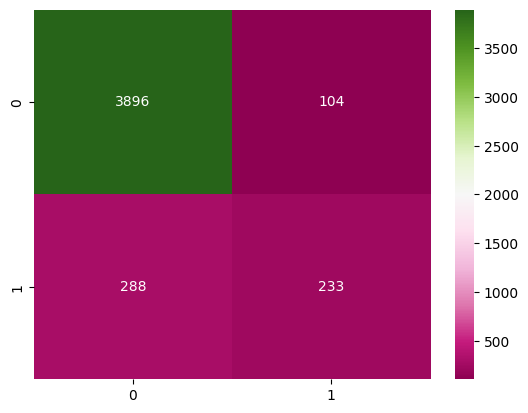

In [170]:
import seaborn as sns

sns.heatmap(confusion_matrix(y,predictions),annot=True,fmt='d',cmap="PiYG")